<a href="https://colab.research.google.com/github/Idowuilekura/smart_ads-a-b-testing-project/blob/master/smart_adds_a_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math as mt
from scipy.stats import norm
from scipy import stats
from statsmodels.stats import weightstats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
smartadds = pd.read_csv('/content/drive/My Drive/AdSmartABdata.csv')

In [4]:
smartadds.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


Data exploration on the dataset


In [5]:
exposed = smartadds[smartadds.experiment=='exposed']
control =smartadds[smartadds.experiment=='control']

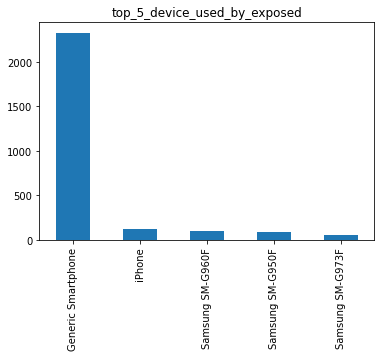

In [6]:
exposed.device_make.value_counts().sort_values(ascending=False).head(5).plot(kind='bar',title='top_5_device_used_by_exposed')

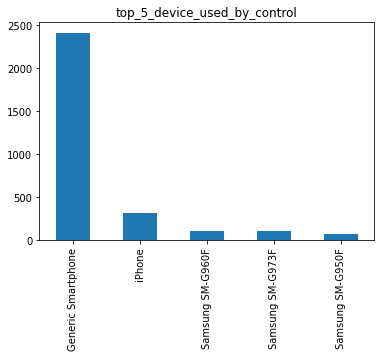

In [7]:
control.device_make.value_counts().sort_values(ascending=False).head(5).plot(kind='bar',title='top_5_device_used_by_control')

The above shows that the genreric smartphoone type is higher in control than exposed


In [8]:
# checking if there are duplicated auction_id
print(smartadds.auction_id.count())
print(smartadds.auction_id.nunique())

8077
8077


It seems the number of people in the experiemnt is are unique

Text(0, 0.5, 'sum of responses')

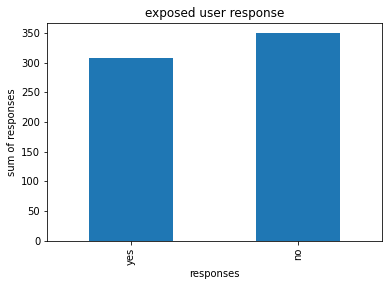

In [9]:
exposed_yes_no = exposed[['yes','no']].sum()
exposed_yes_no.plot(kind='bar',title='exposed user response')
plt.xlabel('responses')
plt.ylabel('sum of responses')

From here we could see that the total number of yes in the exposed group is smlaller than the number of no


Text(0, 0.5, 'sum_of_responses')

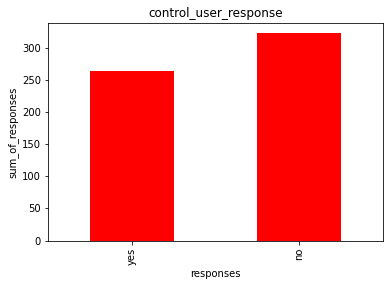

In [10]:
control_response = control[['yes','no']].sum()
control_response.plot(kind='bar',color='r',title='control_user_response')
plt.xlabel('responses')
plt.ylabel('sum_of_responses')

The above scenario still played out in the response of the control group but we can see that the number of yes in the exposed group and no is higher than that of the control

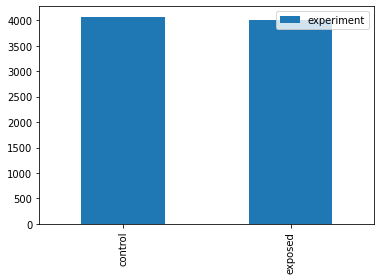

In [11]:
smartadds.experiment.value_counts().plot(kind='bar',legend=True)

The number of people in the control group is slighly higher than that of users in the exposed group

In [12]:
smartadds.experiment.value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

we need to perform a sanity check to scale both groups to be in the same range since the numbers in the control is quite more than those in the experiment, this will be sone in the next step


In [13]:
exposed = smartadds[smartadds.experiment=='exposed']
control = smartadds[smartadds.experiment=='control']

In [14]:
print(exposed['device_make'].value_counts().head())
print(control['device_make'].value_counts().head())

Generic Smartphone    2332
iPhone                 122
Samsung SM-G960F        99
Samsung SM-G950F        82
Samsung SM-G973F        58
Name: device_make, dtype: int64
Generic Smartphone    2411
iPhone                 311
Samsung SM-G960F       104
Samsung SM-G973F        96
Samsung SM-G950F        66
Name: device_make, dtype: int64


In [15]:
print(control['browser'].value_counts().head())
print(exposed['browser'].value_counts().head())

Chrome Mobile            2410
Facebook                  561
Samsung Internet          492
Chrome Mobile WebView     292
Mobile Safari             246
Name: browser, dtype: int64
Chrome Mobile            2144
Chrome Mobile WebView    1197
Samsung Internet          332
Facebook                  203
Mobile Safari              91
Name: browser, dtype: int64


Our invariant metrics are the numbers of people who are in the exposed & control group,the device_make, browser and platform_os
We will perform sanity checks on theses columns

let us check if there is any difference in those that clicked yes or no to the total numbers of people that saw the ads in both groups

In [16]:
smartadds.experiment.value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

let us check if this is statistically significant, to do this we expect the number of views in the control group to be about 50% of the total number of views in both groups. Since our model follows a binomial distribution of yes and no, we can model it with the biniomaial. If we use a 0.5 then theprobability of clicking should around 0.5 in both groups, we will also be using confidence interval which tells us which range an obseved p can exist and can be acceptablea the expected value

In [17]:
control_adds_viewed = len(control)

In [18]:
# definning the z_score function
def get_z_score(alpha):
  return norm.ppf(alpha)

In [19]:
p= 0.5 
alpha =0.05 # using a 95% confidence
p_hat = control_adds_viewed/len(smartadds)
sd =mt.sqrt(p*(1-p)/len(smartadds))
ME= round(get_z_score(1-(alpha/2))*sd,4)
print("The confidence interval is between",p-ME,"and",p+ME,"; Is", p_hat,"insdie ths range")

The confidence interval is between 0.4891 and 0.5109 ; Is 0.504023771202179 insdie ths range


Our observed p_hat is inside this range which means the difference in number of samples between groups is expected. So far so good, since this invariant metric test is successful and hence the difference is not statistically significance

In [20]:
grouped_responses=smartadds.groupby('experiment')[['yes','no']].sum().reset_index(
)
print(grouped_responses)
print(grouped_responses.sum(axis=1))
print(grouped_responses.sum(axis=1).sum())

  experiment  yes   no
0    control  264  322
1    exposed  308  349
0    586
1    657
dtype: int64
1243


Here we can see that there is a difference in number of clicks of either yes or no in both groups, let us check ifit is statistically significant

In [21]:
# let us use similar procedure that we used for numbers in the group
p= 0.5 
alpha =0.05 # using a 95% confidence
control_adds_clicked = 587
total_adds_clicked =1243
p_hat = control_adds_clicked/total_adds_clicked
sd =mt.sqrt(p*(1-p)/total_adds_clicked)
ME= round(get_z_score(1-(alpha/2))*sd,4)
print("The confidence interval is between",p-ME,"and",p+ME,"; Is", p_hat,"insdie ths range")

The confidence interval is between 0.4722 and 0.5278 ; Is 0.47224456958970235 insdie ths range


Since our p_hat is in between the two ranges we can confidently say that the sanity checked is okay

Let us go to specifying our hypothesis, the null and the alternative hypothesis

the null hypothesis is that the proportion of people that clicked yes in both group is not different and the alternative is that there is a difference 
$Ho -H1 =0$ null hypothesis
$Ho -H1\neq 0$ alternative hypothesis





In [22]:
control_yes_click_rate = len(control[control.yes==1])/len(control[(control.yes==1)|(control.no==1)])
print(control_yes_click_rate)

0.45051194539249145


In [23]:
exposed_yes_click_rate = len(exposed[exposed.yes==1])/len(exposed[(exposed.yes==1)|(exposed.no==1)])
print(exposed_yes_click_rate)

0.4687975646879756


visuslly there seems to be a difference but we do not know if it is statistically significance, we we check visually and analytical

In [24]:
weightstats.ztest(control['yes'],exposed['yes'],alternative='two-sided')

(-2.108610239127817, 0.03497823834674959)

The p-value of the classical a/b testing is 0.03 which is smaller than 0.05 if we are using alpha = 0.05, hence we are 95% confidence of rejecting the null hypotheis and say that there is a statistical significance difference. From here we can see that there is a brand increase awareness in the exposed group

## Sequential hypothesis testing

In [25]:
!pip install git+https://github.com/Idowuilekura/Sequential-Probability-Ratio-Test

  Cloning https://github.com/Idowuilekura/Sequential-Probability-Ratio-Test to /tmp/pip-req-build-kjrj80nl
  Running command git clone -q https://github.com/Idowuilekura/Sequential-Probability-Ratio-Test /tmp/pip-req-build-kjrj80nl
  Created wheel for sprt: filename=sprt-0.0.1-cp36-none-any.whl size=4648 sha256=ec97005c8a03a754b8bf0c1c794a681c0437e1ca1737f86aeec14ba17e6e425b
  Stored in directory: /tmp/pip-ephem-wheel-cache-zlv33rpx/wheels/c3/a4/0a/a6491baa3ac84d0ca75edd988ea4bfb4a2758a7840c1c28485
Successfully built sprt


In [26]:
import sprt as sprt

$Ho=rate of people that clicked yes $ null hypothesis
$H1=rate of people that clicked yes in exposed$ alternative hypothesis

In [27]:
h0 = control_yes_click_rate
h1 = exposed_yes_click_rate
values = control.yes[(control.yes==1)|(control.no==1)].values
alpha = 0.05
beta = 0.2
test = sprt.SPRTBinomial(h0=h0,h1=h1,alpha=alpha,beta=beta,values=values)


Decision:	Continue

     values    lower    upper
n                            
577     261  244.054  302.871
578     262  244.513  303.331
579     262  244.973  303.790
580     262  245.433  304.250
581     262  245.892  304.710
582     263  246.352  305.169
583     263  246.812  305.629
584     264  247.271  306.089
585     264  247.731  306.548
586     264  248.191  307.008


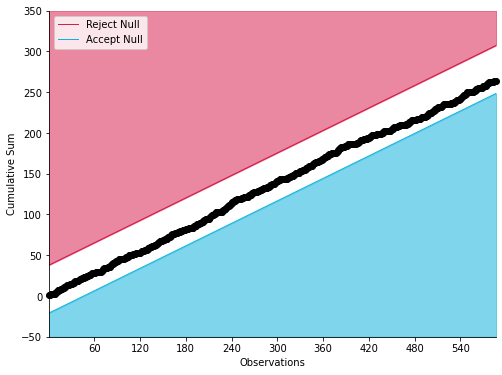

In [28]:
test.plot()

From here we could see that if the experiment is ran longer then there will not be a statistically significant difference and hence we will likely fail to reject the hypothesis

# Task 2.2 Machine Learning

In max three statements, make a problem formulation for machine learning and specify the target variable

We want to use machine learning to predict if users in the exposed will click yes answers more than those in control group, although we have used statistics to see a difference in both groups but we do not knowwhat factors drive the yes responsesin both group, we will be using machine learning to account for those features.

Train a machine learning model using 5-fold cross validation the following 3 different algorithms:
Logistic Regression 
Decision Trees
XGBoost


In [29]:
# importing needed machine learning libraries
import xgboost as xgb
import sklearn 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score
from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import StandardScaler

In [30]:
#let us view our dataset
smartadds.head()
values_predicted = smartadds['yes']
smartadds_copy = smartadds.copy()
smartadds_copy.drop(['auction_id','date','hour','yes','no'],axis=1,inplace=True)

In [31]:
values_predicted.values.reshape(1,-1)

array([[0, 0, 0, ..., 0, 0, 0]])

In [32]:
smartadds_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   experiment   8077 non-null   object
 1   device_make  8077 non-null   object
 2   platform_os  8077 non-null   int64 
 3   browser      8077 non-null   object
dtypes: int64(1), object(3)
memory usage: 252.5+ KB


since we have columns with categorical features we will need to use label_encoder to numerically encode the categorical feautures

In [33]:
object_column_list = list(smartadds_copy.select_dtypes(include=['object']).columns)
object_column_list

['experiment', 'device_make', 'browser']

In [34]:
new_predictors_df = smartadds_copy


In [35]:
label_encoder = LabelEncoder()
standard_scaler = StandardScaler()

In [36]:
# initializing the encoder_function
def label_encoder_column(df,col):
  col_labelled = label_encoder.fit_transform(df[col])
  col_transformed = standard_scaler.fit_transform(col_labelled.reshape(-1,1))
  return col_transformed

In [37]:
for col in object_column_list:
  new_predictors_df[col] = label_encoder_column(new_predictors_df,col)

In [38]:
new_predictors_df['platform_os'] = standard_scaler.fit_transform(np.array(new_predictors_df['platform_os']).reshape(-1,1))

In [39]:
new_predictors_df.head()

,experiment,device_make,platform_os,browser
0,1.008080,-0.669861,0.235674,-0.563142
1,1.008080,-0.669861,0.235674,-0.563142
2,1.008080,-0.911660,0.235674,-0.294699
3,-0.991985,0.624475,0.235674,0.510630
4,-0.991985,-0.669861,0.235674,-0.563142


Split the dataset into training and testing data

In [40]:
#using train_split of sklearn 
X_train,X_test,y_train,y_test = train_test_split(new_predictors_df,values_predicted,test_size=0.3,random_state=1)

In [41]:
# cheking if it was properly splitted
round((len(X_train)/len(new_predictors_df))*100)

70

In [42]:
X= new_predictors_df
y= values_predicted

performing cross validation with the data and calculating each models log function 

In [43]:
my_scorer = make_scorer(log_loss)

In [44]:
X.shape

(8077, 4)

In [45]:
logistic_model = LogisticRegression()
values=cross_validate(logistic_model,X.values,y,cv=5,scoring=my_scorer)

In [46]:
values['test_score']

array([2.4578956 , 2.4578956 , 2.43803127, 2.43803127, 2.43803127])

In [47]:
val=cross_val_score(logistic_model, X.values, y, cv=5, scoring='neg_log_loss')
print(val)

[-0.25371526 -0.25557815 -0.25321994 -0.25240473 -0.25300017]


In [48]:
decision_tree_classifier = DecisionTreeClassifier()
val_tree = cross_val_score(decision_tree_classifier,X.values,y,cv=5,scoring=my_scorer)

In [49]:
val_tree

array([2.62888409, 2.6075101 , 2.50219148, 2.56635168, 2.54496495])

In [50]:
xgb_classifier = xgb.XGBClassifier()
xgb_val = cross_val_score(xgb_classifier,X.values,y,cv=5,scoring='neg_log_loss')
xgb_val

array([-0.25393112, -0.25689088, -0.25309598, -0.25145321, -0.25747407])

Compute feature importance - what’s driving the model? Which parameters are important predictors for the different ML models? What contributes to the goal of gaining more “Yes” results?
Which data features are relevant to predicting the target variable?
Explain what the difference is between using A/B testing to test a hypothesis vs using Machine learning to learn the viability of the same effect?
Explain the purpose of training using k-fold cross validation instead of using the whole data to train the ML models?
What information do you gain using the Machine Learning approach that you couldn’t obtain using A/B testing?


#Computing the various features importance for all the models

In [51]:
logistic_model.fit(X,y)
importance = logistic_model.coef_[0]

In [52]:
original_features_list = list(X.columns)
log_dict = {}
c = 0
for i in original_features_list:
    if c < len(importance)-1:
        log_dict[i] = importance [c]
    c+=1

In [53]:
print(log_dict)

{'experiment': 0.07132066376544673, 'device_make': 0.0900876261278198, 'platform_os': 0.4562172279485216}


In [54]:
decision_tree_classifier.fit(X,y)
importance_tree = decision_tree_classifier.feature_importances_

In [55]:
dec_dict = {}
c = 0
for i in original_features_list:
    if c < len(importance)-1:
        dec_dict[i] = importance [c]
    c+=1

In [56]:
print(dec_dict)

{'experiment': 0.07132066376544673, 'device_make': 0.0900876261278198, 'platform_os': 0.4562172279485216}


In [57]:
xgb_classifier.fit(X,y)
importance_xg = xgb_classifier.feature_importances_

In [58]:
xgb_dict = {}
c = 0
for i in original_features_list:
    if c < len(importance)-1:
        xgb_dict[i] = importance [c]
    c+=1

In [59]:
print(xgb_dict)

{'experiment': 0.07132066376544673, 'device_make': 0.0900876261278198, 'platform_os': 0.4562172279485216}


From here we could see that the features that drives all the model most is the platform_os of the user followed by the device_make of the users who are seeing the adds. The platfom_os drives the propability of getting a yes or a no

Explain what the difference is between using A/B testing to test a hypothesis vs using Machine learning to learn the viability of the same effect? Explain the purpose of training using k-fold cross validation instead of using the whole data to train the ML models? What information do you gain using the Machine Learning approach that you couldn’t obtain using A/B testing?

The difference between using a/b testing to test hypothesis vs using machine learning to learn the viability of the same effect, is that while a/b tells us if there is a difference between each group,machine learning helps us to know which features are causing the difference betweeen each results, this is googd because we can know what is making users to respond to a particular result or not

The purpose of using k-fold cross validation instead of using the whole data to train the ML model is that,k-fold segments the dataset, trains on one and test on the remaining until the number of k is exhausted, it is helpful because it helps to reduce bias and variance. the information that i gained using machine learning is the features that drive the responses, whcih can not be gotten in the tranditional way